# Exploring Cook County Housing



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

In [1]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included `codebook.txt` file (you can optionally open this by first clicking the `data` folder, then clicking `codebook.txt` file in the navigation pane). Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression. Just run the cells below: 

In [2]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

Let's load the initial data.

In [3]:
initial_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 204,792 observations and 62 features in training data
assert initial_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in initial_data.columns.values

The next order of business is getting a feel for the variables in our data.  A more detailed description of each variable is included in `codebook.txt` (in the same directory as this notebook).  **You should take some time to familiarize yourself with the codebook before moving forward.**

Let's take a quick look at all the current columns in our initial data.

In [5]:
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [6]:
initial_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Contextualizing the Data

Although we've already explored this dataset and its social context in Lecture 15, let's refresh our memory on the background of our dataset before diving into a full-scale analysis. 

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 1a

Based on the columns in this dataset and the values that they take, what do you think each row represents? That is, what is the granularity of this dataset? 

Based on the column names provided, each row in this dataset represents a single property or real estate parcel. The granularity of the data is at the individual property level, containing a wide range of characteristics and information for each property.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Question 1b
Why do you think this data was collected? For what purposes? By whom?

This question calls for your speculation and is looking for thoughtfulness, not correctness. 

This dataset was likely collected by a local government agency for multiple interconnected purposes. The primary goal would be property tax assessment, given the detailed property characteristics and valuation data. However, its comprehensive nature also makes it valuable for urban planning and real estate market analysis. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Question 1c

Craft at least two questions about housing in Cook County that can be answered with this dataset and provide the type of analytical tool you would use to answer it (e.g. "I would create a ___ plot of ___ and ___" or "I would calculate the ___ [summary statistic] for ___ and ____"). Be sure to reference the columns that you would use and any additional datasets you would need to answer that question.

How does the sale price of properties vary based on their distance from O'Hare Airport and the level of airport noise exposure?

Analytical approach: I would create a scatter plot with a color gradient, where:

X-axis: "Longitude"
Y-axis: "Latitude"
Color scale: "Sale Price"
Point size: "O'Hare Noise" level



What is the relationship between a property's age and its repair condition, and how does this impact sale prices across different neighborhoods?

Analytical approach: I would create a grouped box plot where:

X-axis: "Age Decade"
Y-axis: "Sale Price"
Grouping: "Repair Condition"
Facet: "Neighborhood Code"

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---
## Question 1d

Suppose now, in addition to the information already contained in the dataset, you also have access to several new columns containing demographic data about the owner, including race/ethnicity, gender, age, annual income, and occupation. Provide one new question about housing in Cook County that can be answered using at least one column of demographic data and at least one column of existing data and provide the type of analytical tool you would use to answer it.

How does the relationship between property value and building square footage vary across different income levels and racial/ethnic groups in Cook County?
Analytical approach: I would create a scatter plot with multiple trend lines, where:

X-axis: "Building Square Feet"
Y-axis: "Estimate (Building)"
Color: "Race/Ethnicity"
Separate plots or facets: Income brackets derived from "Annual Income"

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In Project A2, you will be building a linear regression model that predicts sales prices using training data, but it's important to first understand how the structure of the data informs such a model. In this section, we will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

Note that we will perform EDA on the **initial data**.

### Sale Price
We begin by examining the distribution of our target variable `Sale Price`. We have provided the following helper method `plot_distribution` that you can use to visualize the distribution of the `Sale Price` using both the histogram and the box plot at the same time. Run the following 2 cells.

In [7]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

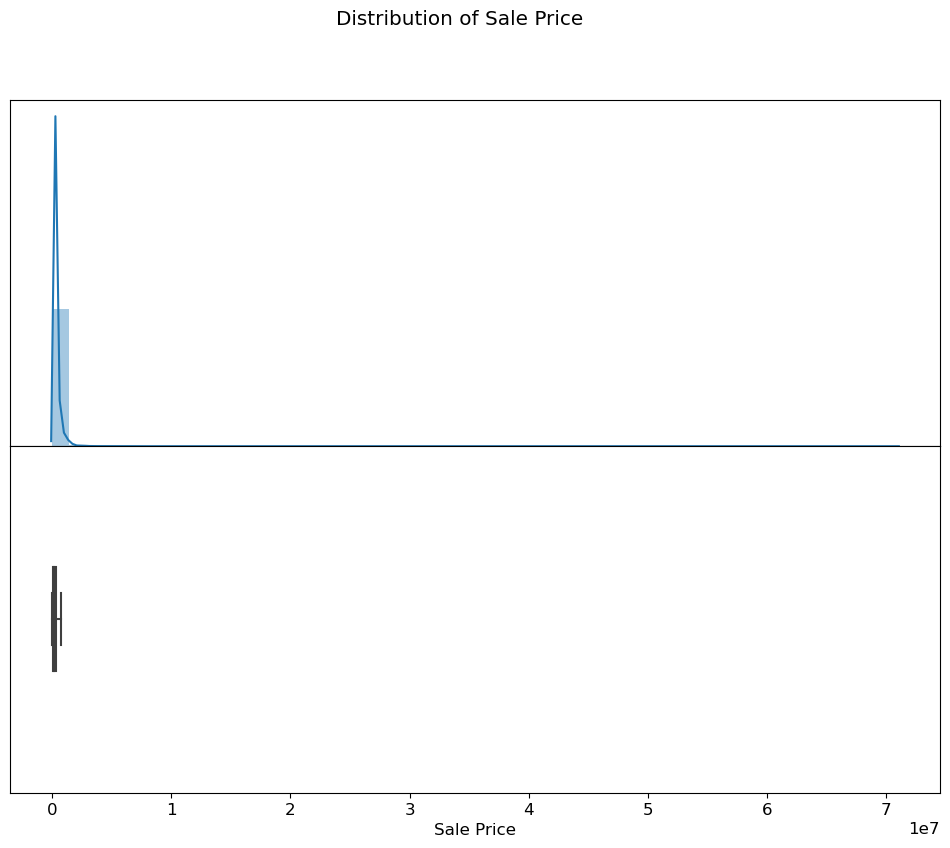

In [8]:
plot_distribution(initial_data, label='Sale Price')

We can see that the data is highly skewed to the right currently, probably because of some extremely expensive houses. To get a clearer view of the distribution, run the following cell to examine a more limited range of house prices from [\\$0, \\$1,000,000]. 

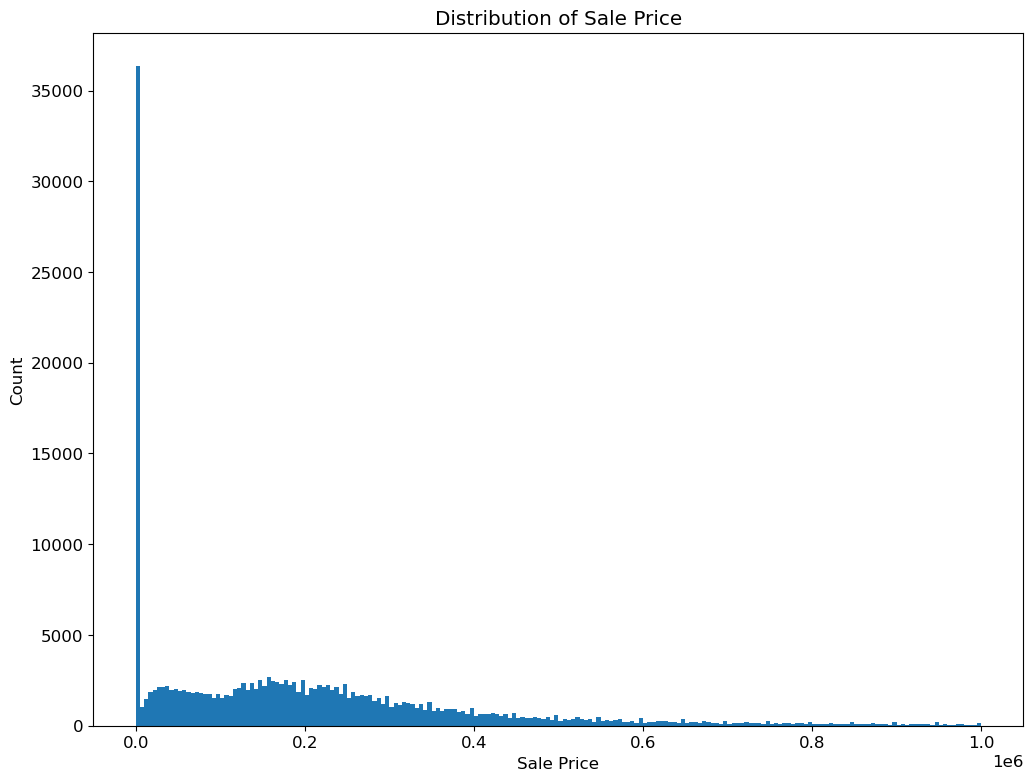

In [9]:
no_right_outliers = initial_data[initial_data['Sale Price'] <= 1000000]['Sale Price']
plt.hist(no_right_outliers, bins=200)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Distribution of Sale Price")
plt.show()

Interestingly, we also see this spike near in the smallest bin of our `Sale Price` distribution, something that wasn't immediately evident from our initial plot. Run the following cell to see which values are the most common.

In [10]:
initial_data['Sale Price'].value_counts()

Sale Price
1         35546
250000     1252
200000     1232
150000     1189
175000     1118
          ...  
216756        1
70050         1
358590        1
215700        1
142515        1
Name: count, Length: 14720, dtype: int64

This should be immediately concerning. While we don't know the exact reason why so many houses were reported as \\$1 (most likely a placeholder value of some sort), including these data points in any model would heavily skew the fit. After all, most houses are worth more than \\$1!

<br><br>

---
## Question 2a

Our findings with the \\$1 entries indicates something interesting may be happening with small valued `Sale Price`s. In the cell below, use `value_counts()` to assess the count of entries for `Sale Prices` in the range of [\\$0, \\$500). Then assign `q2a` to a **list** of the **top 3 most** common `Sale Price`s as integers within the range of [\\$0, \\$500) in descending order of counts.

In [23]:
values0_500 = initial_data[(initial_data['Sale Price'] >= 0) & (initial_data['Sale Price'] <= 500)]['Sale Price'].value_counts()
q2a = values0_500.head(3).tolist()
q2a

[35546, 277, 19]

This exploration has indicated to us that moving forward we should probably pick a cutoff to get rid of smaller, probably unrepresentative `Sale Price`s. As a result, moving forward you will be asked to only look at households whose price is at least \\$500 dollars. While this cutoff is slightly arbitrary, this decision was made to address these unrealistically low values. 

On the other hand, there are also the upper-bound outliers that skewed our data in the first place. Run the cell below to find the proportion of how many buildings sold for over \\$1,000,000.

In [25]:
len(initial_data[initial_data['Sale Price'] > 1000000]) / len(initial_data[initial_data['Sale Price'] >= 500])

0.034114520129520334

Since there's only around 3% (or 5,000) buildings that have sold over \\$1,000,000 it would definitely be reasonable to build a model for the [\\$500, \\$1,000,000] range. For ProjA1 though, we're going to try and build a model to handle the entire range from [\\$500, infinity). As a result, we will need to reason with how the outliers shape the distribution of points. One way we can make our initial visualization more legible is by log-transforming our data to neutralize the impact of the right outliers.

<br><br>

---
## Question 2b

As previously established to zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this assignment. In addition, it may be a good idea to apply a log transformation to `Sale Price`. In the cell below, assign `training_data` to a new `DataFrame` that is the same as `initial_data` **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

**You should NOT remove or modify the original column `Sale Price` as it will be helpful for later questions.** If you accidentally remove it, just restart your kernel and run the cells again.

**Note**: This also implies from now on, our target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

*To ensure that any error from this part does not propagate to later questions, there will be no hidden tests for this question.*

In [27]:
training_data = initial_data[initial_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,2,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925


Let's create a new distribution plot using the log-transformed sale prices. As a sanity check, you should see that the distribution for `Log Scale Price` is much more uniform.

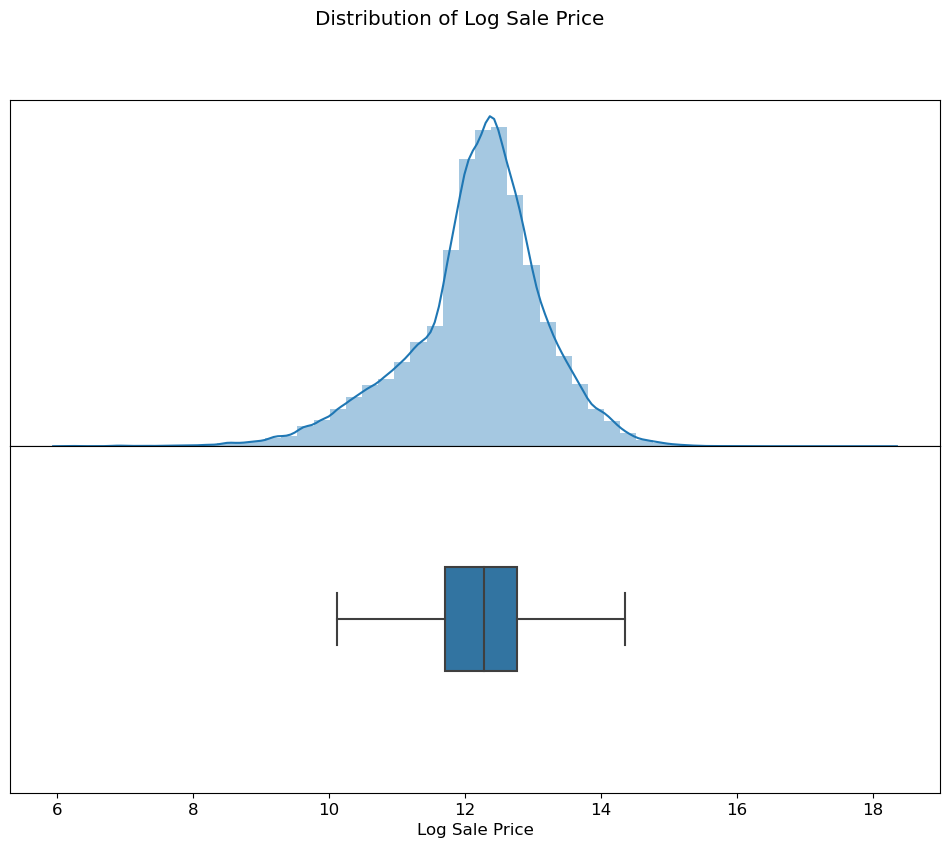

In [29]:
plot_distribution(training_data, label='Log Sale Price');

<br><br>

---
## Question 3a


Is the following statement correct? Assign your answer to `q3statement`.

     "At least 25% of the properties in the training set sold for more than $200,000.00."

**Note:** The provided test for this question does not confirm that you have answered correctly; only that you have assigned `q3statement` to `True` or `False`.

In [30]:
# This should be set to True or False
q3statement = True

<br><br>

---
## Question 3b

Next, we want to explore if there is any correlation between `Log Sale Price` and the total area occupied by the property. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick — it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our `training_data` that contains the log-transformed area occupied by each property. 

**You should NOT remove or modify the original `Building Square Feet` column as it will be used for later questions**. If you accidentally remove it, just restart your kernel and run the cells again.

*To ensure that any errors from this part do not propagate to later questions, there will be no hidden tests for this question.*

In [32]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

<!-- BEGIN QUESTION -->

<br><br>

---
## Question 3c

In the visualization below, we created a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, would `Log Building Square Feet` make a good candidate as one of the features for our model? Why or why not?

**Hint:** To help answer this question, ask yourself: what kind of relationship does a “good” feature share with the target variable we aim to predict?

![Joint Plot](images/q2p3_jointplot.png)


Based on the jointplot, Log Building Square Feet appears to be a good candidate as a feature for predicting Log Sale Price. The visualization reveals a strong positive correlation between the two variables, with a clear linear trend that is consistent across the range of building sizes. 

<!-- END QUESTION -->

<br><br>

---
## Question 4

Continuing from the previous part, as you explore the dataset, you might still run into more outliers that prevent you from creating a clear visualization or capturing the trend of the majority of the houses. 

Write a function `remove_outliers` that removes outliers from the dataset based on a threshold value of a variable. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` should return a copy of `data` with only observations that satisfy `Building Square Feet` less than 8000 (exclusive) and `Building Square Feet` greater than 500 (exclusive).

**Note:** The provided tests simply check that the `remove_outliers` function you defined does not mutate the input data in-place. They do not check that you have implemented `remove_outliers` correctly so that it works with any data, variable, lower, and upper bound.

In [34]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] > lower) & (data[variable] < upper)]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: Feature Engineering

In this section, we will walk you through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.

<br><br>

---
## Question 5a

Let's take a closer look at the `Description` column first. Compare the description for a few rows. For the following list of variables, how many of them can be extracted from the `Description` column? Assign your answer to a list of integers corresponding to the statements that you think are true (ie. `[1, 2, 3]`).

1. The date the property was sold on.
2. The number of stories the property contains.
3. The previous owner of the property.
4. The address of the property.
5. The number of garages the property has.
6. The total number of rooms inside the property.
7. The total number of bedrooms inside the property.
8. The total number of bathrooms inside the property.

In [ ]:
# optional cell for scratch work 

In [43]:
q5a = [1, 2, 4, 6, 7, 8]

In [54]:
training_data['Description'].iloc[4]

'This property, sold on 10/26/2017, is a one-story with partially livable attics houeshold located at 2820 186TH ST.It has a total of 6 rooms, 4 of which are bedrooms, and 1.5 of which are bathrooms.'

<br><br>

---
## Question 5b

Write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (**as integers**) for each house. Treat missing values as zeros, if necessary. Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

**Hint**: You should consider inspecting the `Description` column to figure out if there is any general structure within the text. Once you have noticed a certain pattern, you are set with the power of RegEx!

In [56]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r'(\d+) of which are bedrooms').astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)



<!-- BEGIN QUESTION -->

<br><br>

---
## Question 5c

Create a visualization that clearly and succinctly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:
- It should avoid overplotting.
- It should have clearly labeled axes and a succinct title.
- It should convey the strength of the correlation between `Sale Price` and the number of rooms: in other words, you should be able to look at the plot and describe the general relationship between `Log Sale Price` and `Bedrooms`.

**Hint**: A direct scatter plot of the `Sale Price` against the number of rooms for all of the households in our training data might risk overplotting.

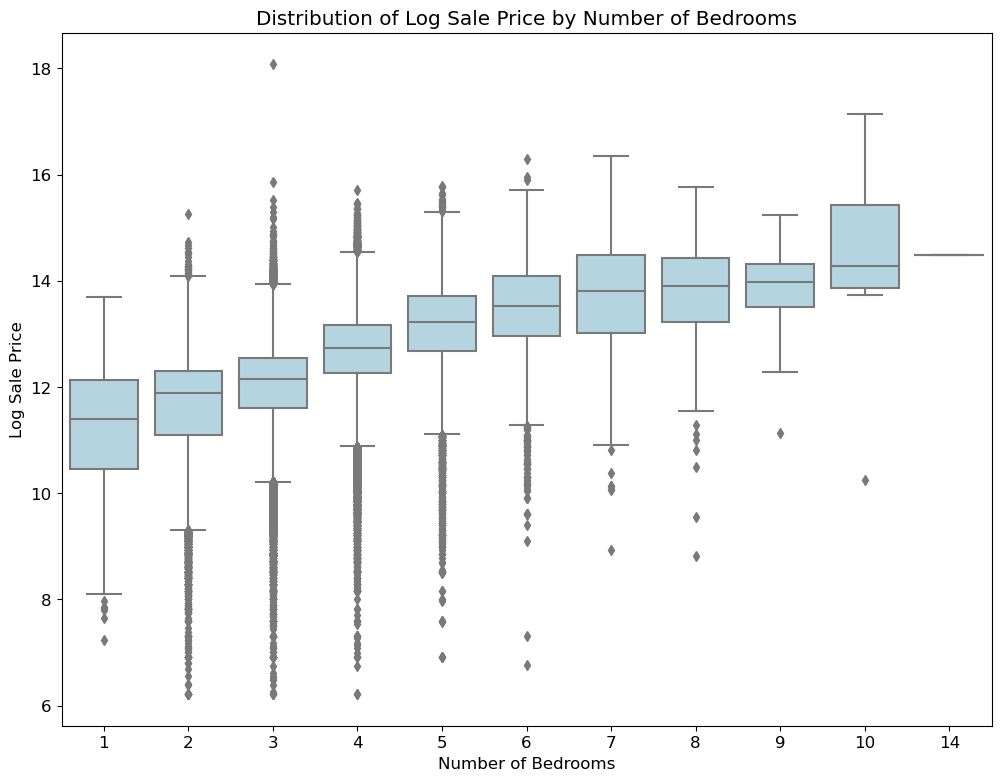

In [87]:
sns.boxplot(x='Bedrooms', y='Log Sale Price', data=training_data, 
            color='lightblue', whis=1.5)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Log Sale Price')
plt.title('Distribution of Log Sale Price by Number of Bedrooms')
plt.show()

<!-- END QUESTION -->

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column, `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

<br><br>

---
## Question 6a

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` to the total number of unique neighborhoods in `training_data`. 


In [83]:
num_neighborhoods = len(training_data['Neighborhood Code'].unique())
num_neighborhoods


193

<br><br>

---
## Question 6b

If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we get the following visualization.


![overplot](images/q5p2_catplot.png)


In [85]:
# Feel free to create a cell below this and run plot_categorical(training_data) if you want to see what this function outputs.
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Oh no, looks like we have run into the problem of overplotting again! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most popular neighborhoods. We define the top 20 most popular neighborhoods as being the 20 neighborhood codes that have the greatest number of property sales within them.

In [100]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().head(20).index
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]
in_top_20_neighborhoods

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2
8,13232040260000,205,70,3100.0,71,0.0,2.0,2.0,1.0,3.0,...,10.0,1,1.0,70,7170,"This property, sold on 08/25/2016, is a two-st...",3100.0,13.422468,7.636270,4
10,19074270080000,202,380,3750.0,72,0.0,1.0,1.0,2.0,3.0,...,7.4,1,1.0,380,72380,"This property, sold on 05/01/2017, is a one-st...",3750.0,11.695247,6.841615,2
11,15083050330000,203,20,5092.0,31,0.0,2.0,1.0,1.0,1.0,...,5.8,1,1.0,20,3120,"This property, sold on 04/29/2014, is a one-st...",5092.0,11.184421,6.911747,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204781,20361190390000,203,80,4405.0,70,0.0,2.0,1.0,1.0,3.0,...,5.7,1,1.0,80,7080,"This property, sold on 07/15/2013, is a one-st...",4405.0,10.913269,7.141245,3
204785,9284030280000,202,40,6650.0,22,0.0,1.0,1.0,1.0,3.0,...,6.1,1,1.0,40,2240,"This property, sold on 04/03/2014, is a one-st...",6650.0,11.736069,6.761573,3
204786,8141120110000,203,100,10010.0,16,0.0,2.0,1.0,1.0,1.0,...,5.6,1,1.0,100,16100,"This property, sold on 09/08/2016, is a one-st...",10010.0,12.568978,6.948897,3
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017,7.092574,3


Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

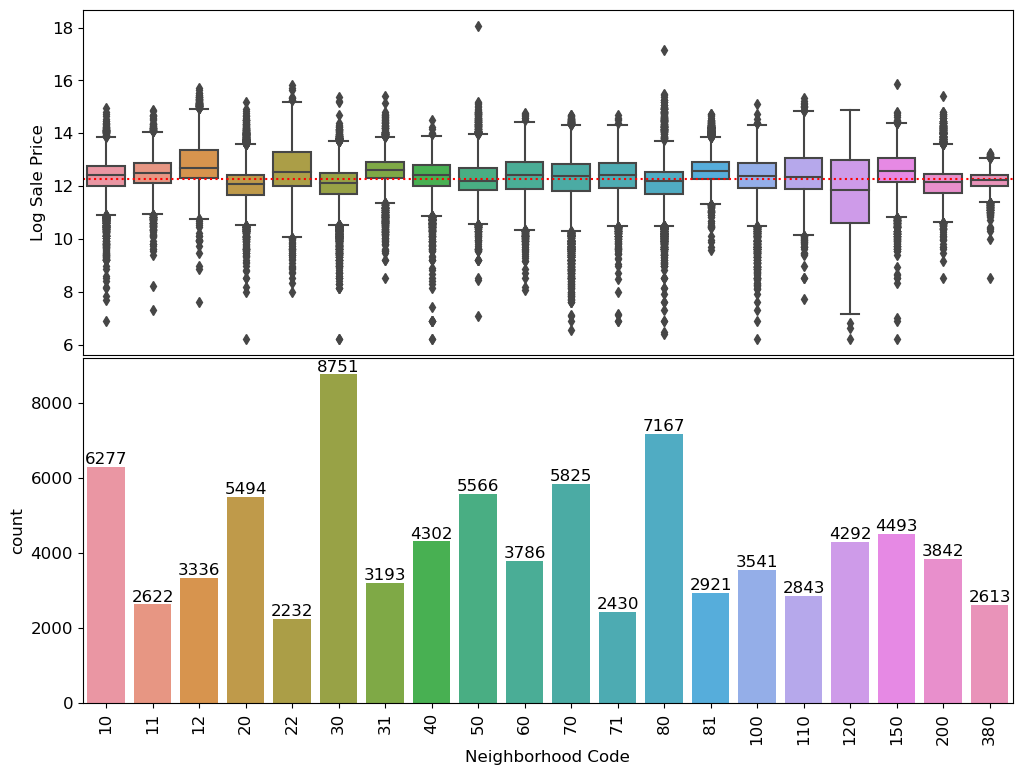

In [102]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

<br><br>

---
## Question 6c

From the plot above, we can see that there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. We’ll categorize our neighborhoods in a crude way. In this question, we’ll compute how “expensive” each neighborhood is by aggregating the `Log Sale Price`s for all properties in a particular neighborhood using a `metric`, such as the median. We’ll use this `metric` to find the top `n` most expensive neighborhoods. Then, in `q6d`, we’ll label these “expensive neighborhoods” and leave all other neighborhoods unmarked.

Fill in `find_expensive_neighborhoods` to return a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by our choice of aggregating function, `metric`.

For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` should return the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes. 

In [103]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least an int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhood_prices = data.groupby('Neighborhood Code')['Log Sale Price'].agg(metric)
    neighborhoods = neighborhood_prices.sort_values(ascending=False).head(n).index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in NumPy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

<br><br>

---
## Question 6d

We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write an additional function `add_in_expensive_neighborhood` that takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`). You can think of `expensive_neighborhoods` as being the output of the function `find_expensive_neighborhoods` from `q6c`. 

Using these inputs, `add_in_expensive_neighborhood` should add a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not. This type of variable is known as an **indicator variable**.

**Hint:** `pd.Series.astype` [(documentation)](https://pandas.pydata.org/docs/reference/api/pandas.Series.astype.html) may be useful for converting `True`/`False` values to integers.

In [110]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      expensive_neighborhoods (list of ints): ints should be the neighborhood codes of
        neighborhoods pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In the following question, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

<br><br>

---
## Question 7a

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Roof Material (Nominal): 

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

Write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material. Your function should return a new `DataFrame`, not modify the existing `DataFrame`. If you modify the existing `DataFrame` by accident, you can load `training_data` again in `q2b`.

**Hint**: the `DataFrame.replace` ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html)) method may be useful here.

In [119]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      new DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    
    new_data = data.copy()
    roof_material_map = {
        1: "Shingle/Asphalt",
        2: "Tar & Gravel",
        3: "Slate",
        4: "Shake",
        5: "Tile",
        6: "Other"
    }
    
    new_data['Roof Material'] = new_data['Roof Material'].map(roof_material_map)
    
    return new_data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


<br><br>

---
## Question 7b

#### An Important Note on One-Hot-Encoding 

Unfortunately, simply replacing the integers with the appropriate strings isn’t sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data. For more information on why we want to use one-hot-encoding, refer to this [link](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

Complete the following function `ohe_roof_material` that returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `Roof Material_MATERIAL`. Your function should return a new `DataFrame` and **should not modify the existing `DataFrame`**.

You should use `scikit-learn`’s `OneHotEncoder` to perform the one-hot-encoding. `OneHotEncoder` will automatically generate column names of the form `Roof Material_MATERIAL`. Refer back to the video walkthrough for Question 1 of Lab 7 for an example of its use. Unlike in the lab example however, in this problem we only wish to construct the one-hot-encoding columns **without removing any columns**.

In [132]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    ohe = OneHotEncoder()
    ohe.fit(data[['Roof Material']])
    
    new_data = ohe.transform(data[['Roof Material']]).toarray()
    new_df = pd.DataFrame(data= new_data, columns= ohe.get_feature_names_out(), index= data.index)
    
    return data.join(new_df)

training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)
training_data_ohe.head(10)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,12.560244,6.904751,3,0,0.0,0.0,1.0,0.0,0.0,0.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,9.998798,6.810142,3,0,0.0,0.0,1.0,0.0,0.0,0.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,12.323856,7.068172,3,0,0.0,0.0,1.0,0.0,0.0,0.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,10.025705,6.855409,2,0,0.0,0.0,1.0,0.0,0.0,0.0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,11.512925,7.458186,4,0,0.0,0.0,1.0,0.0,0.0,0.0
7,4172060130000,208,52,9844.0,25,0.0,1.0,Shingle/Asphalt,3.0,3.0,...,13.586097,8.272315,4,0,0.0,0.0,1.0,0.0,0.0,0.0
8,13232040260000,205,70,3100.0,71,0.0,2.0,Tar & Gravel,1.0,3.0,...,13.422468,7.636270,4,0,0.0,0.0,0.0,0.0,1.0,0.0
9,2291070550000,203,33,9600.0,29,0.0,1.0,Shingle/Asphalt,4.0,3.0,...,12.506177,7.343426,3,0,0.0,0.0,1.0,0.0,0.0,0.0
10,19074270080000,202,380,3750.0,72,0.0,1.0,Shingle/Asphalt,2.0,3.0,...,11.695247,6.841615,2,0,0.0,0.0,1.0,0.0,0.0,0.0
11,15083050330000,203,20,5092.0,31,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,11.184421,6.911747,3,0,0.0,0.0,1.0,0.0,0.0,0.0
